In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import wordcloud 
from wordcloud import WordCloud
import statistics
from collections import Counter
import datetime
import textblob
from textblob import TextBlob
import sklearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'FYP', 'report', 'ALL', 'traditional ML methods', 'd4')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

In [4]:
fake = pd.read_csv('/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project/FAKE.csv')
true = pd.read_csv('/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project/REAL.csv')

In [5]:
fake

,text,type
0,\n21st Century Wire says<U+2026> \nAs western ...,fake
1,\n21st Century Wire says<U+2026> \n21WIRE repo...,fake
2,\nIn a stunning turn of events 11 days before ...,fake
3,A tidal wave of revelations is pouring out of ...,fake
4,"November 1, 2016 By 21wire 4 Comments \nPatric...",fake
...,...,...
11936,It DOES allow you to put a dog face on top of ...,fake
11937,Wait till you see what happens to the valuatio...,fake
11938,I'm waiting for the one that puts a pussy on m...,fake
11939,$4 Billion even after they are known to be kee...,fake


In [6]:
true

,text,type
0,"They stood in line at Trump Tower, sometimes u...",real
1,Donald J. Trump <U+2019>s foundation informed ...,real
2,President-elect Donald J. Trump won the White ...,real
3,An investment pitch for a new Texas hotel is t...,real
4,President-elect Donald J. Trump <U+2019>s wife...,real
...,...,...
8069,Most conservatives who oppose marriage equalit...,real
8070,The freshman senator from Georgia quoted scrip...,real
8071,The State Department told the Republican Natio...,real
8072,"ADDIS ABABA, Ethiopia <U+2014>President Obama ...",real


In [7]:
#Create column with labels
fake["label"] = "fake"
true["label"] = "true"

In [8]:
#Check shapes of dataframes. I scraped 1844 articles to add to this dataset.
print (fake.shape)
print (true.shape)

(11941, 3)
(8074, 3)


In [9]:
#True news has location and publisher, which fake doesn't have. Remove for consistency
true["text"] = true['text'].apply(lambda x: x.partition("-")[2])

In [10]:
fake.drop("type", axis=1, inplace=True)
true.drop("type", axis=1, inplace=True)

In [11]:
#Remove articles with only pictures / no text
true = true[true["text"] != ""] 
fake = fake[fake["text"] != ""]

In [12]:
#The datasets are pretty balanced, which is good!
print(fake.shape)
print(true.shape)

(11941, 2)
(7472, 2)


In [13]:
import ipywidgets as widgets
from IPython import display
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(fake.head(5))
with widget2:
    display.display(true.head(5))

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
hbox

In [14]:
fake.to_csv('fakeForModeling.csv')
!cp fakeForModeling.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

In [15]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11941 entries, 0 to 11940
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11941 non-null  object
 1   label   11941 non-null  object
dtypes: object(2)
memory usage: 279.9+ KB


In [16]:
true.to_csv('trueForModeling.csv')
!cp trueForModeling.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

In [17]:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
  
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english', 'arabic'))
stop_words.extend(["said", "reuters", "CNN", "would", "image", "via"]) #extend stopwords to include these words too

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def process(df, word_list, by_article_list):
  for article in (df["text"]):
    words = word_tokenize(article)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [20]:
#NOTE: If rerunning, this cell will take a while
process(fake, words_in_f, words_in_each_article_f)

In [21]:
#NOTE: If rerunning, this cell will take a while
process(true, words_in_t, words_in_each_article_t)

In [22]:
from collections import Counter

bigrams_true = zip(words_in_t, words_in_t[1:])
bigram_counts_true = Counter(bigrams_true)
bigrams_true = pd.DataFrame(bigram_counts_true.most_common(20), columns=["Bigram", "Count"])
bigrams_true

,Bigram,Count
0,"(donald, trump)",5338
1,"(new, york)",5031
2,"(hillary, clinton)",3981
3,"(white, house)",3259
4,"(united, state)",2760
5,"(last, week)",1594
6,"(clinton, campaign)",1499
7,"(trump, campaign)",1462
8,"(president, obama)",1449
9,"(secretary, state)",1392


In [23]:
bigrams_false = zip(words_in_f, words_in_f[1:])
bigram_counts_false = Counter(bigrams_false)
bigrams_false = pd.DataFrame(bigram_counts_false.most_common(20), columns=["Bigram", "Count"])
bigrams_false

,Bigram,Count
0,"(hillary, clinton)",7861
1,"(donald, trump)",5682
2,"(united, state)",4680
3,"(white, house)",2515
4,"(new, york)",2384
5,"(clinton, campaign)",1606
6,"(de, la)",1438
7,"(secretary, state)",1402
8,"(clinton, foundation)",1356
9,"(bill, clinton)",1239


In [24]:
trigrams_true = zip(words_in_t, words_in_t[1:], words_in_t[2:])
trigram_counts_true = Counter(trigrams_true)
trigrams_true = pd.DataFrame(trigram_counts_true.most_common(20), columns=["Trigram", "Count"])
trigrams_true

,Trigram,Count
0,"(new, york, time)",1122
1,"(today, paper, subscribe)",832
2,"(page, new, york)",826
3,"(new, york, edition)",815
4,"(york, edition, headline)",815
5,"(president, barack, obama)",777
6,"(bill, scher, thomas)",648
7,"(scher, thomas, wright)",648
8,"(thomas, wright, joshua)",648
9,"(wright, joshua, zeitz)",648


In [25]:
trigrams_false = zip(words_in_f, words_in_f[1:], words_in_f[2:])
trigram_counts_false = Counter(trigrams_false)
trigrams_false = pd.DataFrame(trigram_counts_false.most_common(20), columns=["Trigram", "Count"])
trigrams_false

,Trigram,Count
0,"(new, york, time)",874
1,"(director, james, comey)",451
2,"(fbi, director, james)",419
3,"(dakota, access, pipeline)",416
4,"(president, united, state)",360
5,"(private, email, server)",321
6,"(hillary, clinton, campaign)",301
7,"(president, barack, obama)",301
8,"(black, life, matter)",272
9,"(standing, rock, sioux)",272


In [26]:
wordcounts_t = Counter(words_in_t)
wordcounts_f = Counter(words_in_f)

In [27]:
mostcommon_t = Counter(wordcounts_t).most_common(20)
mostcommon_f = Counter(wordcounts_f).most_common(20)

t_plot = dict(mostcommon_t)
mostcommon_t = pd.DataFrame(mostcommon_t, columns = ["Word", "Count"])
mostcommon_t = mostcommon_t.reset_index(drop=True)
mostcommon_t = mostcommon_t['Word'].tolist()

f_plot = dict(mostcommon_f)
mostcommon_f = pd.DataFrame(mostcommon_f, columns = ["Word", "Count"])
mostcommon_f = mostcommon_f.reset_index(drop=True)
mostcommon_f = mostcommon_f['Word'].tolist()

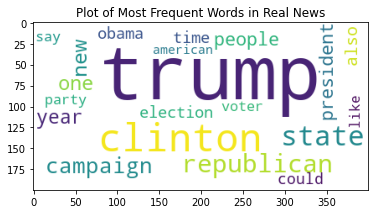

In [28]:
t_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(t_plot)

plt.imshow(t_wc)
plt.title("Plot of Most Frequent Words in Real News")
plt.show()

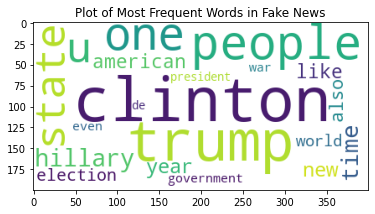

In [29]:
f_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(f_plot)

plt.imshow(f_wc)
plt.title("Plot of Most Frequent Words in Fake News")
plt.show()

In [30]:
#Of the top 20 words in each class, 9 words are common 
len(set(mostcommon_t) & set(mostcommon_f))

13

In [31]:
#Get tokenized forms of all articles (true and fake) in one dataframe
X = []
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)

In [32]:
#Get labels of all articles (true and fake) in one dataframe
y = pd.concat([true["label"], fake["label"]])
y = [1 if x == "fake" else 0 for x in y] #1 and 0 for ease of tokenizing

In [33]:
articles = pd.DataFrame(X)
y = pd.DataFrame(y, columns=["label"])

In [34]:
articles.to_csv('articles.csv')
!cp articles.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

y.to_csv('labels.csv')
!cp labels.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

In [35]:
import sklearn.model_selection as ms

#Create 80-20 train test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state=1)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Keep words that appear in greater than 10% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.1, preprocessor = ' '.join)

#Implement on train dataset
response_train = tfidf.fit_transform(X_train) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()

In [37]:
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)
df_train

,able,according,across,act,action,actually,added,administration,ago,almost,along,already,also,always,america,american,among,another,anyone,anything,appears,area,around,article,asked,attack,away,back,barack,based,become,began,behind,believe,best,better,big,bill,black,business,...,tuesday,turn,twitter,two,united,university,use,used,using,victory,video,view,vote,voter,voting,wall,want,war,washington,way,wednesday,week,well,went,whether,white,whose,win,within,without,woman,word,work,working,world,write,wrote,year,yet,york
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.123092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.137603,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.248053,0.0,0.16112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.412135,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.153655,0.000000,0.0,0.128700
1,0.080608,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170191,0.0,0.065642,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060206,0.000000,0.081801,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.054462,0.068863,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.061520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.128444,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.14274,0.060512,0.0,0.000000,0.000000,0.00000,0.000000,0.073981,0.000000,0.161660,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.068501,0.000000,0.078693,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103863,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.080056,0.00000,0.075224,0.000000,0.104266,0.000000,0.0,0.000000
4,0.027537,0.042213,0.000000,0.0,0.0,0.078252,0.080209,0.051531,0.026285,0.000000,0.0,0.000000,0.121589,0.000000,0.044946,0.092153,0.000000,0.000000,0.029182,0.027668,0.029070,0.0,0.022425,0.073126,0.026351,0.207373,0.000000,0.019853,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.028342,0.0,0.0,0.018294,0.068985,0.000000,0.023372,0.000000,0.0,0.0,0.000000,0.106344,0.000000,0.0,0.00000,0.028661,0.020358,0.385282,0.023656,0.000000,0.000000,0.041135,0.020030,0.027945,0.000000,0.000000,0.0,0.000000,0.00000,0.023451,0.0,0.000000,0.000000,0.00000,0.060718,0.000000,0.000000,0.078313,0.0,0.046994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15525,0.000000,0.000000,0.000000,

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = ' '.join, vocabulary = feature_names_train)

#Implement on test dataset
response_test = tfidf.fit_transform(X_test) #This is the Sparse Document-Term Matrix
feature_names_test = tfidf.get_feature_names()
dense_test = response_test.todense() #This is the Dense Document-Term Matrix
denselist_test = dense_test.tolist()

In [39]:
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)
df_test

,able,according,across,act,action,actually,added,administration,ago,almost,along,already,also,always,america,american,among,another,anyone,anything,appears,area,around,article,asked,attack,away,back,barack,based,become,began,behind,believe,best,better,big,bill,black,business,...,tuesday,turn,twitter,two,united,university,use,used,using,victory,video,view,vote,voter,voting,wall,want,war,washington,way,wednesday,week,well,went,whether,white,whose,win,within,without,woman,word,work,working,world,write,wrote,year,yet,york
0,0.000000,0.046656,0.0,0.000000,0.000000,0.000000,0.000000,0.057315,0.000000,0.000000,0.062096,0.000000,0.000000,0.000000,0.050813,0.041889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045308,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.081711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.049325,0.0,0.000000,0.000000,0.052998,0.000000,0.000000,0.000000,0.000000,0.046154,0.000000,0.000000,0.035741,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.066179,0.000000,0.000000,0.064071,0.000000,0.000000,0.000000,0.000000,0.038008,0.000000,0.056803,0.000000,0.060121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.071514,0.000000,0.0,0.000000,0.000000,0.000000,0.180542,0.000000,0.000000,0.072208,0.000000,0.000000,0.000000,0.000000,0.000000,0.072717,0.000000,0.000000,0.0,0.046877,0.000000,0.000000,0.152183,0.00000,0.118263,0.055139,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072259,0.000000,0.039954,0.000000,0.000000
2,0.023117,0.000000,0.0,0.022689,0.022166,0.021999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038191,0.000000,0.000000,0.000000,0.020137,0.018146,0.000000,0.023073,0.000000,0.000000,0.019008,0.335475,0.000000,0.000000,0.021974,0.033928,0.000000,0.000000,0.0000,0.000000,0.000000,0.020609,0.000000,0.00000,0.000000,0.120463,0.000000,0.0,...,0.000000,0.045943,0.0,0.000000,0.039011,0.000000,0.020157,0.000000,0.000000,0.048370,0.000000,0.022730,0.037947,0.000000,0.048884,0.000000,0.017192,0.000000,0.0,0.000000,0.000000,0.017419,0.016991,0.00000,0.079221,0.000000,0.0,0.021124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023759,0.000000,0.041497,0.000000
3,0.155484,0.000000,0.0,0.000000,0.149087,0.073983,0.000000,0.000000,0.000000,0.078544,0.000000,0.000000,0.085625,0.000000,0.063982,0.000000,0.000000,0.000000,0.000000,0.077594,0.159697,0.000000,0.000000,0.070513,0.000000,0.000000,0.000000,0.000000,0.000000,0.082200,0.0000,0.000000,0.077399,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.135575,0.000000,0.080774,0.000000,0.000000,0.000000,0.063809,0.000000,0.000000,0.000000,0.115633,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081392,0.000000,0.000000,0.069777,0.000000
4,0.049602,0.000000,0.0,0.032455,0.000000,0.078672,0.000000,0.030698,0.047813,0.016704,0.033258,0.000000,0.009105,0.016576,0.054430,0.011218,0.000000,0.000000,0.017608,0.000000,0.016982,0.033301,0.013595,0.000000,0.000000,0.015653,0.094297,0.048533,0.000000,0.034964,0.0154,0.017977,0.000000,0.014741,0.015716,0.03058,0.000000,0.014360,0.490896,0.0,...,0.000000,0.000000,0.0,0.010941,0.013951,0.137620,0.000000,0.014733,0.017179,0.000000,0.032317,0.016258,0.000000,0.000000,0.017482,0.000000,0.110666,0.028538,0.0,0.056149,0.000000,0.012459,0.133674,0.00000,0.000000,0.475523,0.0,0.045326,0.000000,0.014193,0.028649,0.016023,0.051051,0.015985,0.049439,0.000000,0.000000,0.038285,0.014840,

In [40]:
#This is the final data to be used for training models
df_train.to_csv('training_data.csv')
!cp training_data.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

In [41]:
#This is the final data to be used for testing models
df_test.to_csv('testing_data.csv')
!cp testing_data.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

In [42]:
y_train = pd.DataFrame(y_train, columns=["label"])
y_test = pd.DataFrame(y_test, columns=["label"])

In [43]:
#Final labels to be used for training models
y_train.to_csv('train_labels.csv')
!cp train_labels.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

In [44]:
#Final labels to be used for testing models
y_test.to_csv('test_labels.csv')
!cp test_labels.csv "/content/gdrive/My Drive/FYP/report/ALL/traditional ML methods/d4/Project"

From medium Getting Real with Fake news